<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/Mark2_TSFClassifier_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified by: Stephanie Tietz

Original Model from: mohamedameen93 on full German Traffic Sign dataset

https://github.com/mohamedameen93/German-Traffic-Sign-Classification-Using-TensorFlow

Modified to work in TensorFlow 2.0, got rid of functions that were going away soon, and trained on German TS Dataset plus "not a sign" images, optimized for 3 classes first then expanding to 44

Multiclass Image Classification in TensorFlow

In [0]:
import numpy as np
np.random.seed(1187) #to help reproduce

from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
#import random
import cv2
from skimage.filters import rank
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


In [0]:
#upload data
#from google.colab import files

#uploaded = files.upload()

#traindata = np.load('smalltrain.npy') #only 3 classes, both circle signs
#traindata = np.load('alltrain.npy') #all classes

#testdata = np.load('smalltest.npy')
#testdata = np.load('alltest.npy')

In [7]:
traindata = np.load('smalltrain2.npy') #smalltrain2 has triangle sign
testdata = np.load('smalltest2.npy')

print(traindata.shape) #expect (5620, 3073) for triangle dataset, (41109,3073) for all
print(testdata.shape) #expect (1900, 3073) for triangle dataset, (13330,3073) for all
print(testdata)

(5620, 3073)
(1900, 3073)
[[214 217 218 ... 134 136   2]
 [123 123 126 ...  51  47   2]
 [ 98  98  93 ...  99  94   2]
 ...
 [ 21  38  69 ...  37  27   1]
 [ 28  85  10 ...  50  21   0]
 [ 18  35  57 ...  19  29   1]]


In [0]:
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [66]:
#split into x and y
X_train = traindata[:,:-1]
Y_train = traindata[:,-1]
Y_train = Y_train.reshape(len(Y_train),1)
print(X_train.shape)
print(Y_train.shape)

X_test = testdata[:,:-1]
Y_test = testdata[:,-1]
Y_test = Y_test.reshape(len(Y_test),1)
print(X_test.shape)
print(Y_test.shape)

#reshape into (32,32,3) for each example for this model input
X_train = (X_train.reshape(traindata.shape[0], 3, 32, 32)).transpose([0,2,3,1])
print(X_train.shape)
X_test = (X_test.reshape(testdata.shape[0], 3, 32, 32)).transpose([0,2,3,1])
print(X_test.shape)

(5620, 3072)
(5620, 1)
(1900, 3072)
(1900, 1)
(5620, 32, 32, 3)
(1900, 32, 32, 3)


In [67]:
#START OF DATA PREPROCESSING
#Shuffle

from sklearn.utils import shuffle

#Randomize (shuffle) the data
print(Y_test)
X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)
print(Y_test)



[[2]
 [2]
 [2]
 ...
 [1]
 [0]
 [1]]
[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


In [68]:
#Make grayscale
print(X_train.shape)
print(X_test.shape)
grayscale = [0.299,0.587,0.144]

X_test = np.dot(X_test, grayscale)
X_train = np.dot(X_train, grayscale)
print(X_train.shape)
print(X_test.shape)




(5620, 32, 32, 3)
(1900, 32, 32, 3)
(5620, 32, 32)
(1900, 32, 32)


In [69]:
#Normalize data
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
print(X_train.shape)

(5620, 32, 32)


In [71]:
#Expand dimensions to fit 4D input array

X_train = np.expand_dims(X_train,-1)
print(X_train.shape)

X_test = np.expand_dims(X_test,-1)
print(X_test.shape)

(5620, 32, 32, 1)
(1900, 32, 32, 1)


In [72]:
#compute mean image of training set and subtract from training images (not test images)
chann_index_swap = np.swapaxes(X_train,0,3)
mean_image = [[[sum(pixel)/len(pixel) for pixel in col] for col in row] for row in chann_index_swap]
mean_image = np.swapaxes(mean_image,0,2)
mean_image = np.swapaxes(mean_image,0,1)

X_train = X_train - mean_image
print(X_train.shape)

(5620, 32, 32, 1)


In [0]:
num_classes = 3 #change to 44 for alldata

batch_size = 50

num_epochs = 15

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)

#Useful image variables
im_rows = 32
im_cols = 32
image_shape = (32, 32, 1)

#might be useful later
'''
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
'''

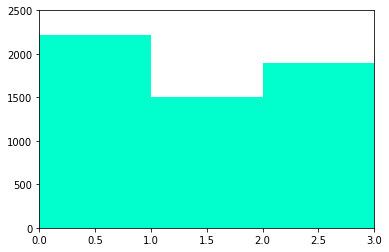

Class with most examples:
0 2220
Class with least examples:
1 1500


In [74]:
#Histogram visualization of classes
hist_data = np.histogram(Y_train, bins=range(num_classes+1))
hist_map = {}
for occr,i in zip(hist_data[0], hist_data[1]):
  hist_map[occr] = i

plt.hist(Y_train, bins=range(num_classes+1), color = '#00ffCC')
plt.axis([0,num_classes,0,2500])
plt.show()
print("Class with most examples:")
print(hist_map[np.amax(hist_data[0])],np.amax(hist_data[0]))
print("Class with least examples:")
print(hist_map[np.amin(hist_data[0])],np.amin(hist_data[0]))


In [0]:
#Create the model
pool_size = (2,2)
kernel_size = (3,3)
num_filters = 32 #number of convolutional filters to use

model = Sequential() #input 32x32x3 (or 32x32x1 if we use greyscale)

#LAYER 1
model.add(Convolution2D) #output 28x28x6
model.add(Activation('relu'))

model.add(Pooling2D) #output 14x14x6

#LAYER 2
model.add(Convolution2D) #output 10x10x16
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size)) #output 5x5x16

model.add(Flatten())

#LAYER 3
model.add(FullyConnected) #output 120 #or Dense?
model.add(Activation('relu'))

#LAYER 4
model.add(FullyConnected) #output 84
model.add(Activation('relu'))

#LAYER 5 - output layer, need num_classes
model.add(FullyConnected) #output num_classes

In [0]:
model.compile(loss='softmax_crossentropy', optimizer='adam', metrics=['accuracy', 'f1score', 'precision', 'recall'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch = num_epoch, verbose=1, validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score: ', score[0])
print('Test accuracy:', score[1])